# EM算法求解GMM模型参数

In [71]:
# 导入各个module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="darkgrid")

current_path = os.getcwd()
output_path = os.path.join(current_path, 'output')

## 数据预处理与可视化

### 导入数据

In [72]:
df = pd.read_excel('hw1_data.xlsx', header=None)
df.columns = ['sex', 'height']
male_df = df[df['sex']=='M']
female_df = df[df['sex']=='F']

### 可视化
男女生身高的频数直方图

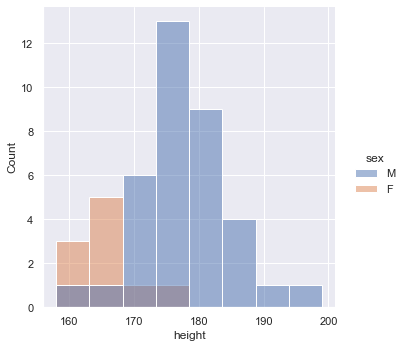

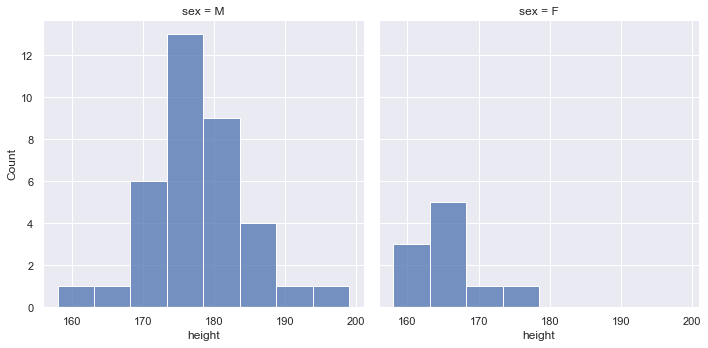

In [73]:
hist_fig1 = sns.displot(df, x='height', hue='sex')
hist_fig2 = sns.displot(df, x='height', col='sex')

hist_fig_name = 'hist_fig.pdf'
output_fig_path = os.path.join(output_path, hist_fig_name)
hist_fig1.savefig(output_fig_path, dpi=400)

使用饼图显示男女生比例

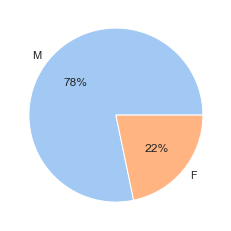

In [74]:
sex_cnt = df['sex'].value_counts()
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]
#create pie chart
plt.pie(sex_cnt.values, labels = list(sex_cnt.index), colors = colors, autopct='%.0f%%')

pie_fig_name = 'pie_fig.pdf'
output_fig_path = os.path.join(output_path, pie_fig_name)
plt.savefig(output_fig_path, dpi=400, bbox_inches='tight')

plt.show()

## 计算

1. 取参数的初始值开始迭代

2. E步：根据当前模型参数，计算分模型$k$对观测数据$y_j$的响应度$\hat\gamma_{jk}$

    $$ \hat\gamma_{jk} = \frac{\alpha_k \phi(y_j|\theta_k)}{\sum_{k=1}^K \alpha_k \phi(y_j|\theta_k)} $$

3. M步：计算新一轮迭代的模型参数

4. 重复上面两步直到收敛


正态分布函数

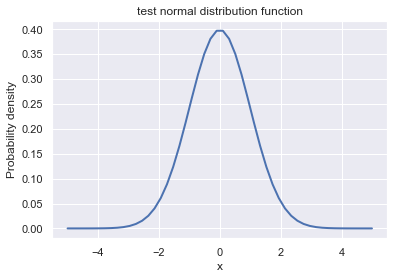

In [75]:
def normal_dist(x, mu, sigma):
    """
    pdf of normal distribution
    :param x:
    :param mu: mean
    :param sigma: variance
    :return:
    """
    a = 1.0 / sigma / np.sqrt(2*np.pi)
    exp = -1.0/2.0*((x-mu)/(sigma))**2
    exp = np.exp(exp)
    return a*exp

test_x = np.linspace(-5, 5)
test_y = normal_dist(test_x, 0.0, 1.0)

# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_y, linewidth=2.0)
ax.set_title('test normal distribution function')
ax.set_xlabel('x')
ax.set_ylabel('Probability density')
plt.show()

Membership probabilities

In [76]:
def membership_prob(x,
                    mu:list,
                    sigma:list,
                    tau:list,
                    idx):
    """
    For the i th data, compute the probability that it belongs to
    the j th model, based on current parameters
    :param x: value of the i th data
    :param mu: list of mean values of all models
    :param sigma: list of variant values of all models
    :param tau: list of weights
    :param idx: index of the model
    :return:
    """
    if len(mu)==len(sigma) and len(sigma)==len(tau):
        pass
    else:
        raise ValueError("The length of the input values is not identical")
    if idx >= len(mu):
        raise IndexError("The index is larger than the number of models")

    denominator = 0
    for j in range(len(mu)):
        denominator += tau[j]*normal_dist(x, mu[j], sigma[j])
    numerator = tau[idx] * normal_dist(x, mu[idx], sigma[idx])

    return numerator/denominator

New parameters

In [77]:
def new_tau(gamma:np.ndarray):
    return np.mean(gamma)

def new_mu(x:np.ndarray, gamma:np.ndarray):
    """
    Calculate the mean of j th model, using all the data
    :param x:
    :param gamma:
    :return:
    """
    if x.size == gamma.size:
        numerator = x * gamma # do multiply element wise
        numerator = np.sum(numerator)
        denominator = np.sum(gamma)
    else:
        raise ValueError("The length of x and gamma should be the same when calculating new mu")
    return numerator/denominator

def new_sigma(x:np.ndarray, gamma:np.ndarray, mu):
    """
    Calculate the variant of j th model, using all the data
    :param x:
    :param gamma:
    :param mu:
    :return:
    """
    if x.size == gamma.size:
        numerator = x - mu
        numerator = numerator**2
        numerator = numerator * gamma
        numerator = np.sum(numerator)
        denominator = np.sum(gamma)
    else:
        raise ValueError("The length of x and gamma should be the same when calculating new sigma")

    return np.sqrt(numerator/denominator)

EM算法计算

In [78]:
def run(max_step, mu1, mu2, sigma1, sigma2, tau1):
    tau2 = 1 - tau1
    stat_label = ['mu1', 'mu2', 'sig1', 'sig2', 'tau1', 'tau2']
    stat_data = [mu1, mu2, sigma1, sigma2, tau1, tau2]
    stat_cnt = [0]*6
    gamma1 = np.zeros(shape=height_data.values.shape)
    gamma2 = np.zeros(shape=height_data.values.shape)
    for i in range(max_step):
        # E STEP
        for j in range(len(height_data.values)):
            gamma1[j] = membership_prob(height_data[j], [mu1, mu2], [sigma1, sigma2], [tau1, tau2], 0)
            gamma2[j] = membership_prob(height_data[j], [mu1, mu2], [sigma1, sigma2], [tau1, tau2], 1)
        # M step
        mu1 = new_mu(height_data.values, gamma1)
        mu2 = new_mu(height_data.values, gamma2)
        sigma1 = new_sigma(height_data.values, gamma1, mu1)
        sigma2 = new_sigma(height_data.values, gamma2, mu2)
        tau1 = new_tau(gamma1)
        tau2 = new_tau(gamma2)
        # record the parameter
        stat_label = stat_label+['mu1', 'mu2', 'sig1', 'sig2', 'tau1', 'tau2']
        stat_data = stat_data + [mu1, mu2, sigma1, sigma2, tau1, tau2]
        stat_cnt = stat_cnt + [i+1]*6
    stat = pd.DataFrame({'step':stat_cnt,'label':stat_label, 'data':stat_data})

    print("EM algorithm for GMM model -- Rsult:")
    print("mu1=",mu1,"mu2=",mu2)
    print("sigma1=",sigma1, "sigma2=",sigma2)
    print("tau1=",tau1, "tau2=",tau2)

    test = pd.DataFrame({"$\mu_1$":[mu1],"$\mu_2$":[mu2], "$\sigma_1$":[sigma1], "$\sigma_2$":[sigma2], "$p_1$":[tau1], "$p_2$":[tau2]})
    print(test)
    return mu1, mu2, sigma1, sigma2, tau1, tau2, stat

In [79]:
def draw_result(mu1, mu2, sigma1, sigma2, filename):
    x_M = np.linspace(155, 200)
    x_F = np.linspace(150, 200)
    pdf_M = normal_dist(x_M, mu1, sigma1)
    pdf_F = normal_dist(x_F, mu2, sigma2)
    # fig = plt.figure()
    fig, ax = plt.subplots()
    sns.histplot(ax=ax, data=df, x='height', hue='sex', stat="density", common_norm=False)
    sns.lineplot(ax=ax, x=x_M, y=pdf_M)
    sns.lineplot(ax=ax, x=x_F,y=pdf_F)
    ax.set_title("Result")
    filename = os.path.join(output_path, filename)
    fig.savefig(filename, dpi=400)

def draw_history(stat, filename):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
    fig.suptitle('History of params during iteration')
    sns.lineplot(ax=axes[0,0], data=stat.query("label=='mu1'"), x="step", y="data", marker='o')
    axes[0,0].set_title('$\mu_1$')
    sns.lineplot(ax=axes[1,0], data=stat.query("label=='mu2'"), x="step", y="data", marker='o')
    axes[1,0].set_title('$\mu_2$')
    sns.lineplot(ax=axes[0,1], data=stat.query("label=='sig1'"), x="step", y="data", marker='o')
    axes[0,1].set_title('$\sigma_1$')
    sns.lineplot(ax=axes[1,1], data=stat.query("label=='sig2'"), x="step", y="data", marker='o')
    axes[1,1].set_title('$\sigma_2$')
    sns.lineplot(ax=axes[0,2], data=stat.query("label=='tau1'"), x="step", y="data", marker='o')
    axes[0,2].set_title('$p_1$')
    sns.lineplot(ax=axes[1,2], data=stat.query("label=='tau2'"), x="step", y="data", marker='o')
    axes[1,2].set_title('$p_2$')

    filename = os.path.join(output_path, filename)
    fig.savefig(filename, dpi=400)



加载数据

In [80]:
df = pd.read_csv('hw1_data.csv', header=None)
df.columns = ['sex', 'height']
height_data = df['height']

## 计算与结果可视化


EM algorithm for GMM model -- Rsult:
mu1= 177.28427949725432 mu2= 164.11589378938336
sigma1= 7.319264254664316 sigma2= 0.9428005047498634
tau1= 0.8612010766793227 tau2= 0.1387989233206773
      $\mu_1$     $\mu_2$  $\sigma_1$  $\sigma_2$     $p_1$     $p_2$
0  177.284279  164.115894    7.319264    0.942801  0.861201  0.138799
EM algorithm for GMM model -- Rsult:
mu1= 177.28427949660465 mu2= 164.11589378931535
sigma1= 7.319264255059287 sigma2= 0.9428005047027699
tau1= 0.8612010767225255 tau2= 0.13879892327747453
      $\mu_1$     $\mu_2$  $\sigma_1$  $\sigma_2$     $p_1$     $p_2$
0  177.284279  164.115894    7.319264    0.942801  0.861201  0.138799
EM algorithm for GMM model -- Rsult:
mu1= 176.74955961795646 mu2= 172.3986702972358
sigma1= 8.23287562075184 sigma2= 7.197744928504974
tau1= 0.7028106707591764 tau2= 0.2971893292408235
     $\mu_1$    $\mu_2$  $\sigma_1$  $\sigma_2$     $p_1$     $p_2$
0  176.74956  172.39867    8.232876    7.197745  0.702811  0.297189


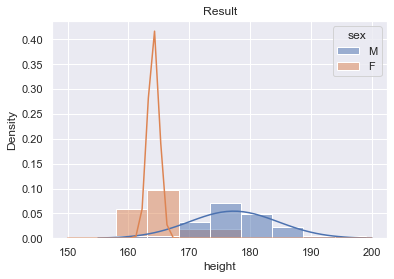

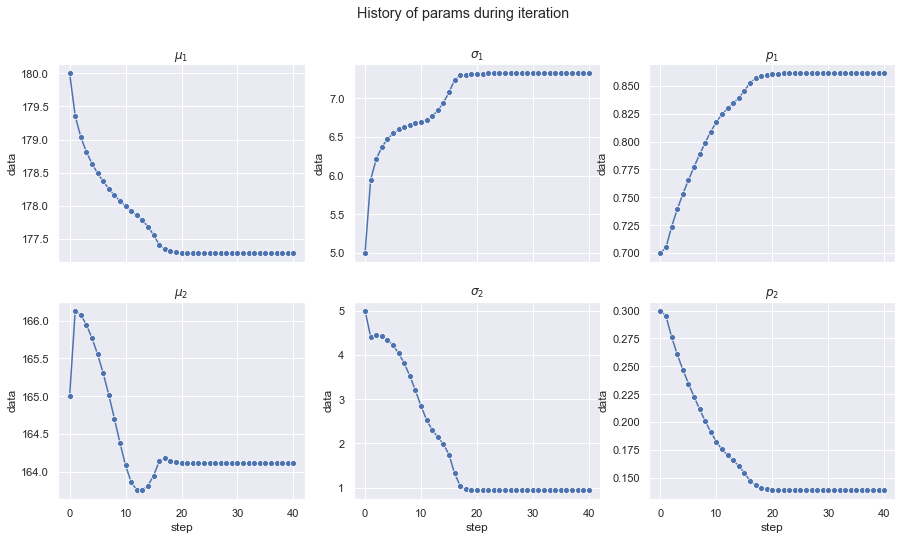

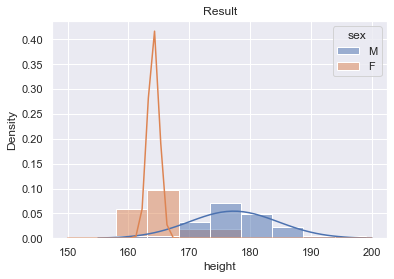

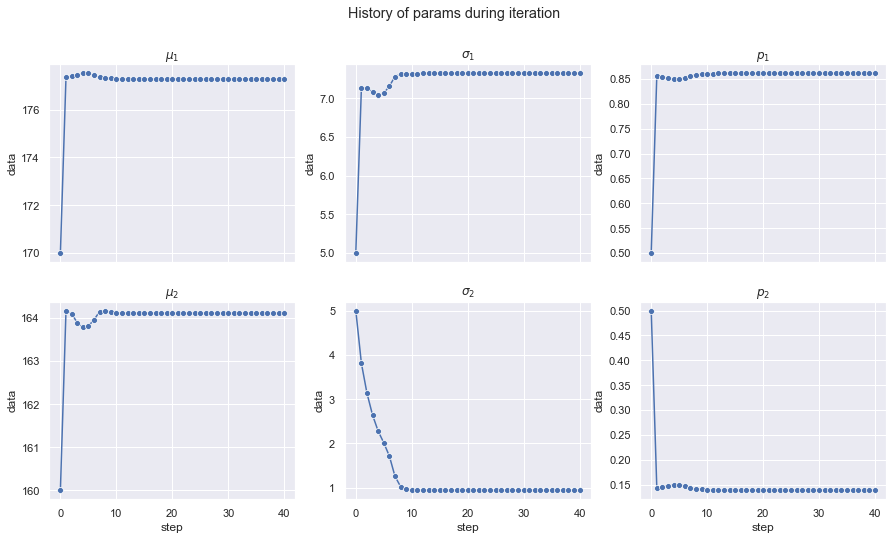

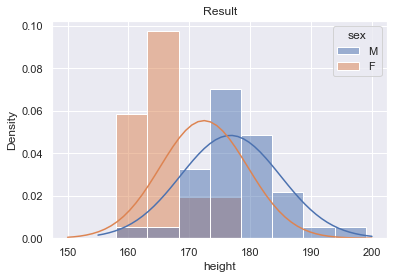

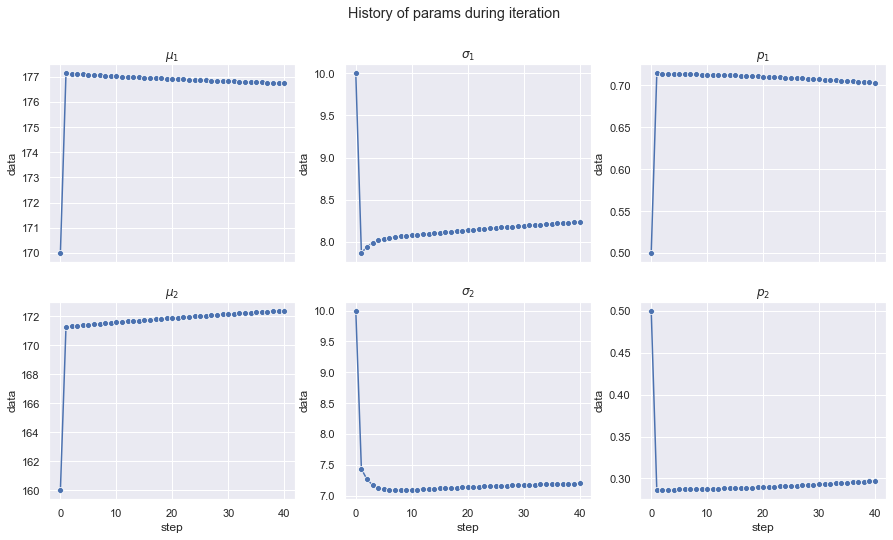

In [82]:
mu1, mu2, sigma1, sigma2, tau1, tau2, stat = run(max_step=40,
        mu1=180, mu2=165, sigma1=5, sigma2=5, tau1=0.7)

draw_result(mu1, mu2, sigma1, sigma2, "result1.pdf")
# 各个参数在计算过程中的变化
draw_history(stat, "history1.pdf")


mu1, mu2, sigma1, sigma2, tau1, tau2, stat = run(max_step=40,
        mu1=170, mu2=160, sigma1=5, sigma2=5, tau1=0.5)

draw_result(mu1, mu2, sigma1, sigma2, "result2.pdf")
# 各个参数在计算过程中的变化
draw_history(stat, "history2.pdf")

mu1, mu2, sigma1, sigma2, tau1, tau2, stat = run(max_step=40,
        mu1=170, mu2=160, sigma1=10, sigma2=10, tau1=0.5)

draw_result(mu1, mu2, sigma1, sigma2, "result3.pdf")
# 各个参数在计算过程中的变化
draw_history(stat, "history3.pdf")